# Flysight GPS

![Drag Racing](../img/product.jpg)

**FlySight is not your mother's GPS.**

FlySight was designed from the ground up for wingsuit pilots and does one truly revolutionary thing...

**FlySight provides real-time audible indication of glide ratio, horizontal or vertical speed.**

If you've used other GPS receivers, you know the drill. When you land, you review data from the jump. If you're lucky, or if you've planned a very simple jump, you might remember what you were doing when your glide ratio maxed out. On the next jump, you try to do it again.

**FlySight speeds the learning process.**

When you change your body position, you instantly hear a change in the tone. Your brain easily connects this feedback with your precise body position, making it astonishingly easy to remember what worked and what didn't.

### Data produced

https://www.monocilindro.com/wp-content/uploads/2016/03/u-blox6-Receiver-Description-Protocol-Specification.pdf
https://www.monocilindro.com/2017/02/22/gps-data-logger-using-arduino-unonano-and-ublox-neo-6m/


| Data   | Unity  | Meaning                                |
| :----- | :----- | :------------------------------------- |
| time   | object | time                                   |
| lat    | deg    | latitude                               |
| lon    | deg    | longitude                              |
| hMSL   | m      | Height Above sea level                 |
| velN   | m/s    | NED north velocity                     |
| velE   | m/s    | NED east velocity                      |
| velD   | m/s    | NED down velocity                      |
| hAcc   | m      | Horizontal Accuracy Estimate           |
| vAcc   | m      | Vertical Accuracy Estimate             |
| sAcc   | m/s    | Speed Accuracy Estimate                |
| gpsFix |        | Position Fix Flags in NMEA MODE        |
| numSV  |        | Number of per-SV data blocks following |

### Imports

In [258]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(color_codes=True)
import plotly.express as px
import datetime as dt
import math
from math import radians, cos, sin, asin, sqrt
import requests
import urllib
import itertools
import time

In [259]:
# inlezen van de dataset
dataset = pd.read_csv('../data/J2.csv', skiprows=[1])
dataset.head()

,time,lat,lon,hMSL,velN,velE,velD,hAcc,vAcc,sAcc,heading,cAcc,gpsFix,numSV
0,2022-06-22T17:17:42.00Z,56.183128,9.042003,-1.500,0.21,-0.63,0.27,135.044,237.804,4.50,0.0,180.00000,3,5
1,2022-06-22T17:17:42.20Z,56.183140,9.042037,-0.849,0.22,-0.66,0.26,91.309,114.913,4.31,0.0,180.00000,3,7
2,2022-06-22T17:17:42.40Z,56.183175,9.041961,9.281,0.09,-0.73,0.29,78.236,110.884,4.53,0.0,180.00000,3,9
3,2022-06-22T17:17:42.60Z,56.183198,9.041965,11.594,0.12,-0.84,0.37,55.382,84.568,3.48,0.0,180.00000,3,9
4,2022-06-22T17:17:42.80Z,56.183208,9.041977,13.536,0.14,-0.91,0.40,43.364,68.466,3.10,0.0,142.73136,3,9


In [260]:
dataset.shape

(4212, 14)

In [261]:
dataset.columns

Index(['time', 'lat', 'lon', 'hMSL', 'velN', 'velE', 'velD', 'hAcc', 'vAcc',
       'sAcc', 'heading', 'cAcc', 'gpsFix', 'numSV'],
      dtype='object')

### Converting Time

In [262]:
def cal_total_seconds():
    datetimes = [pd.to_datetime(d) for d in dataset.time]
    l = []
    for i, d in enumerate(datetimes):
        duration = datetimes[i] - datetimes[0]
        l.append(duration.total_seconds())
    return l

dataset.time = [pd.to_datetime(d) for d in dataset.time]

### Converting units

In [263]:
def meters_to_feet(meters):
    return meters * 3.280839895

def meterpersecond_to_milesperhour(meterpersecond):
    return meterpersecond * 2.236936

def meterpersecond_to_kilometersperhour(meterpersecond):
    return meterpersecond * 3.6

In [264]:
# Calculate Elevation | Fixed or dynamic
def divide_dataset(l, n):
    for i in range(0, len(l), n):
        yield l[i:i + n]

def request_earth_elevation(x):
    s = "https://api.open-elevation.com/api/v1/lookup?locations="
    for i in range(x.index.start, x.index.stop): 
        s += str(x.lat[i]) + "," + str(x.lon[i]) + "|"
    r = requests.get(s[:-1])  
    if r.status_code == 200:
        elevation = pd.json_normalize(r.json(), 'results')['elevation']
        return elevation
    else:
        print(r)
        
def get_earth_elevation():
    l = []
    divided_dataset = list(divide_dataset(dataset, 120))
    for i in range(0, len(divided_dataset)):
        l.append(request_earth_elevation(divided_dataset[i]).values)
        time.sleep(0.07)
    return list(itertools.chain(*l))

def get_dynamic_elevation():
    ground_elevation = meters_to_feet(dataset.hMSL.iloc[-1])
    earth_elevation = [meters_to_feet(e) for e in get_earth_elevation()]
    l = []
    for i in range(0, len(dataset.hMSL)):
        l.append(meters_to_feet(dataset.hMSL[i]) - ground_elevation - earth_elevation[i])
    return l

def get_fixed_elevation(elevation):
    ground_elevation = meters_to_feet(dataset.hMSL.iloc[-1])
    l = []
    for i in range(0, len(dataset.hMSL)):
        l.append(meters_to_feet(dataset.hMSL[i]) - ground_elevation - elevation)
    return l

In [265]:
# Calculating speeds
def calc_horizontal_speed(n, e):
    return math.sqrt((n**2) + (e**2))

def get_vertical_speed():
    return [meterpersecond_to_milesperhour(meter) for meter in dataset.velD]

def get_horizontal_speed():
    return [meterpersecond_to_milesperhour(calc_horizontal_speed(dataset.velN[i], dataset.velE[i])) for i in range(0,len(dataset))]

In [266]:
# Calculating angle
def calc_dive_angle(v_speed, h_speed):
    if h_speed != 0:
        return math.degrees(math.atan(v_speed/h_speed))
    else:
        return 0
    
def get_dive_angle(v_speed, h_speed):
    return [calc_dive_angle(v_speed[i], h_speed[i]) for i in range(0, len(dataset))]

In [267]:
# Calculating horzintal distance
def distance(lat1, lat2, lon1, lon2):
    lon1 = radians(lon1)
    lon2 = radians(lon2)
    lat1 = radians(lat1)
    lat2 = radians(lat2)
      
    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
 
    c = 2 * asin(sqrt(a))
    
    # Radius of earth in kilometers. Use 3956 for miles
    r = 6371
      
    # calculate the result
    return meters_to_feet((c * r) * 1000)


def get_horizontal_distance():
    l, f = [0], 0.0
    for i in range(0, len(dataset)-1):
        f += distance(dataset.lat[i], dataset.lat[i+1], dataset.lon[i], dataset.lon[i+1])
        l.append(f)
    return l

### Creating dataset

In [268]:
def create_dataset():
    return pd.DataFrame({'time': np.array(cal_total_seconds()),
                         'lat': dataset.lat,
                         'lon': dataset.lon,
                         'dynamic_elevation': get_dynamic_elevation(),
                         'fixed_elevation': get_fixed_elevation(0),
                         'earth_elevation': [meters_to_feet(e) for e in get_earth_elevation()],
                         'horizontal_distance': get_horizontal_distance(),
                         'vertical_speed': get_vertical_speed(),
                         'horizontal_speed': get_horizontal_speed(),
                         'dive_angle': get_dive_angle(get_vertical_speed(), get_horizontal_speed())})

df = create_dataset()

In [278]:
df.head()

,time,lat,lon,dynamic_elevation,fixed_elevation,earth_elevation,horizontal_distance,vertical_speed,horizontal_speed,dive_angle
0,0.0,56.183128,9.042003,-306.131890,-148.651575,157.480315,0.000000,0.603973,1.485501,22.125605
1,0.2,56.183140,9.042037,-303.996063,-146.515748,157.480315,7.998011,0.581603,1.556239,20.491909
2,0.4,56.183175,9.041961,-270.761155,-113.280840,157.480315,28.080869,0.648711,1.645327,21.518084
3,0.6,56.183198,9.041965,-263.172572,-105.692257,157.480315,36.605189,0.827666,1.898103,23.559569
4,0.8,56.183208,9.041977,-256.801181,-99.320866,157.480315,40.814353,0.894774,2.059561,23.482493


In [282]:
def get_landing():
    max_id = df.fixed_elevation.idxmax()
    start_of_jump = df.iloc[max_id:]
    return start_of_jump.loc[start_of_jump.fixed_elevation <= 1200]

In [283]:
def get_max_horizontal_speed(dataframe):
    return [dataframe.horizontal_speed.idxmax(), dataframe.horizontal_speed.max()]

get_max_horizontal_speed(get_landing())

[3697, 63.33121376911975]

## Visualisations

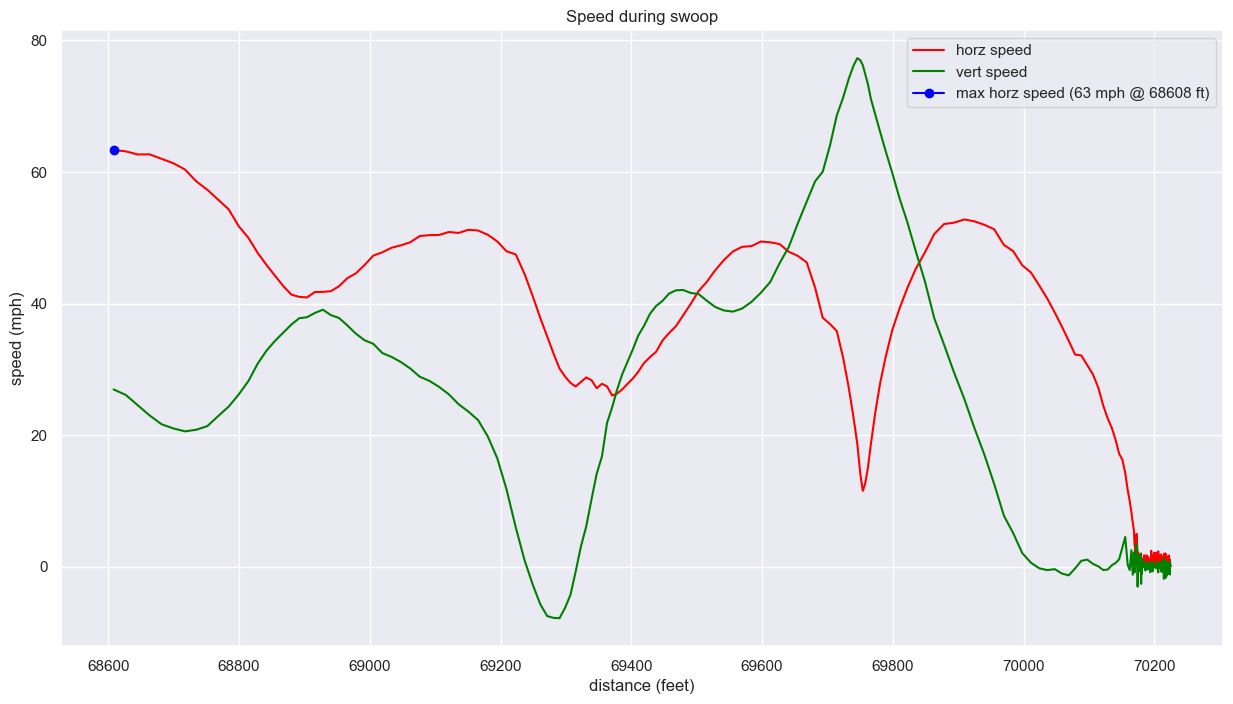

In [284]:
# Speed during swoop
landing = get_landing()
landing = landing.reset_index()

def plot_speed_during_swoop(dataframe):
    max_id = get_max_horizontal_speed(dataframe)[0]
    max_horz_distance = dataframe.horizontal_distance[max_id]
    max_horz_speed = dataframe.horizontal_speed[max_id]

    plt.figure(figsize=(15,8))
    plt.title("Speed during swoop")
    plt.plot(dataframe.horizontal_distance.iloc[max_id:], dataframe.horizontal_speed.iloc[max_id:], color='red', label='horz speed')
    plt.plot(dataframe.horizontal_distance.iloc[max_id:], dataframe.vertical_speed.iloc[max_id:], color='green', label='vert speed')
    plt.plot(max_horz_distance, max_horz_speed, 
             marker="o", color='blue', label=f"max horz speed ({round(max_horz_speed)} mph @ {round(max_horz_distance)} ft)")
    plt.legend()   
    plt.xlabel("distance (feet)")
    plt.ylabel("speed (mph)")
    plt.show()
    
plot_speed_during_swoop(landing)

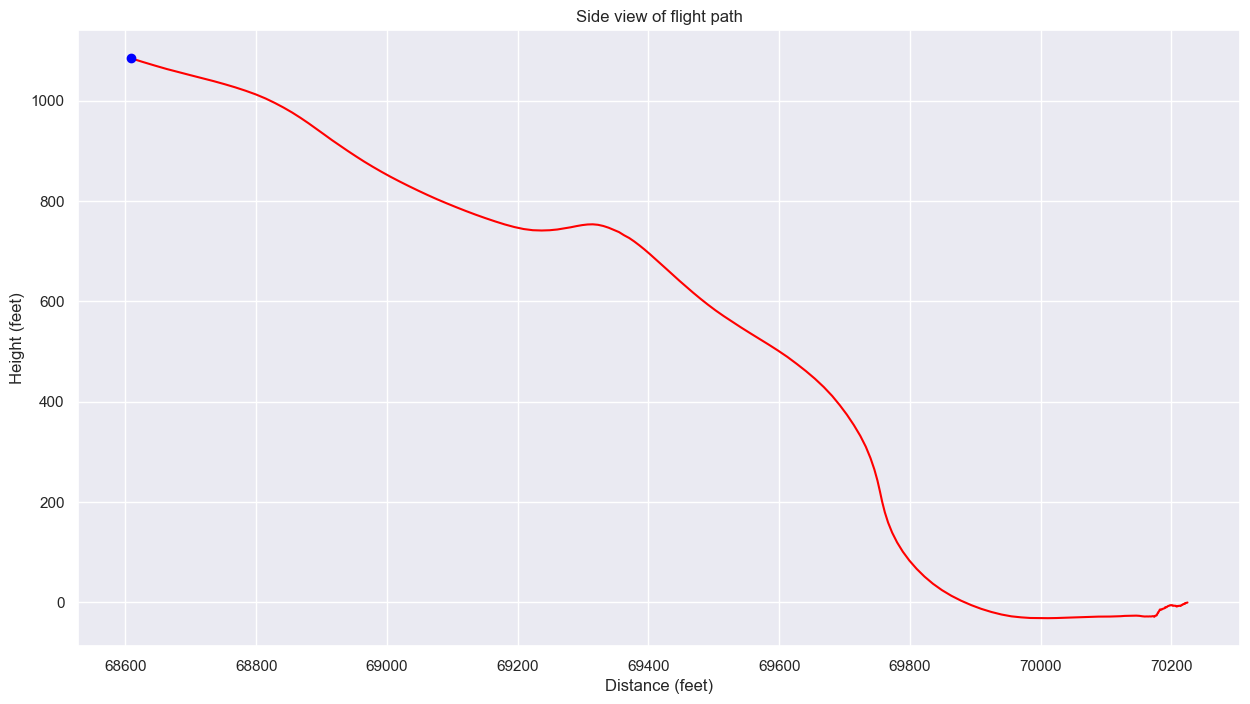

In [285]:
# Side view of flight path
def side_flight_path(dataframe):
    max_id = get_max_horizontal_speed(dataframe)[0]
    max_horz_distance = dataframe.horizontal_distance[max_id]

    plt.figure(figsize=(15,8))
    plt.title("Side view of flight path")
    plt.plot(dataframe.horizontal_distance.iloc[max_id:], dataframe.fixed_elevation[max_id:], color='red')
    plt.plot(dataframe.horizontal_distance[max_id], dataframe.fixed_elevation[max_id], marker="o", color='blue')
    plt.xlabel("Distance (feet)")
    plt.ylabel("Height (feet)")
    plt.show()
    
side_flight_path(landing)

In [274]:
fig = px.line(df, x="time", y="fixed_elevation")
fig.update_traces(mode="lines")
fig.update_xaxes(showspikes=True, spikecolor="black", spikethickness=0.5)
fig.update_yaxes(showspikes=True, spikecolor="black", spikethickness=0.5)
fig.show()

In [275]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df.time,
    y=df.fixed_elevation,
    name="fixed elevation (ft)"
))


fig.add_trace(go.Scatter(
    x=df.time,
    y=df.vertical_speed,
    name="vertical speed",
    yaxis="y2"
))

fig.add_trace(go.Scatter(
    x=df.time,
    y=df.horizontal_speed,
    name="horizontal speed",
    yaxis="y3"
))

# Create axis objects
fig.update_layout(
    xaxis=dict(
        domain=[0.3, 0.8]
    ),
    yaxis=dict(
        title="fixed elevation (ft)",
        titlefont=dict(
            color="#1f77b4"
        ),
        tickfont=dict(
            color="#1f77b4"
        )
    ),
    yaxis2=dict(
        title="vertical speed (mph)",
        titlefont=dict(
            color="#ff7f0e"
        ),
        tickfont=dict(
            color="#ff7f0e"
        ),
        anchor="free",
        overlaying="y",
        side="left",
        position=0.15
    ),
    yaxis3=dict(
        title="horizontal speed (mph)",
        titlefont=dict(
            color="#d62728"
        ),
        tickfont=dict(
            color="#d62728"
        ),
        anchor="x",
        overlaying="y",
        side="right"
    )
)

# Update layout properties
fig.update_layout(
    title_text="Flysight plot",
    width=1000,
    showlegend=False,
)
fig.show()

In [276]:
token = "pk.eyJ1IjoiYWlieWJydW0iLCJhIjoiY2xhdmRldnhyMDRkNTNybWg0NTl6eHgwZSJ9.phqQCg9UWIXx5wFkc_i0kg"

fig = px.line_mapbox(df, lat="lat", lon="lon", zoom=12)
fig.update_layout(mapbox_style="satellite-streets", mapbox_accesstoken=token)
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [277]:
df.to_csv('first_test.csv')